In [53]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# Importing helper functions for pre-processing data
from util import cleaning_data, stemming, wordcloud, tf_idf_vectorizer

In [54]:
# cleanine_data function loads in data, adds labels, removes all punctuation, digits & stop words 
data = cleaning_data("data/true.csv", "data/fake.csv", "title", False)

/Users/oleksandrafilippova/ML_class/final_project/nlp_project_yas/util.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = true_df.append(fake_df).sample(frac=1).reset_index().drop(columns=['index'])


## 1. Data Exploration

Example of the dataset `data` consisting of both labels(1 is True, 0 is Fake):

In [55]:
data

,title,target
0,ryan concerns saudi bill predicts veto override,1
1,clinton expands plan tax wealthy sanders gains...,1
2,undeterred threats gop obstruction obama inter...,0
3,climate change deniers beware doj wants punish...,0
4,sanders firms must take haircut puerto rico de...,1
...,...,...
44893,donald trump longtime butler calls obama kille...,0
44894,kremlin says trump jerusalem decision splittin...,1
44895,boom donald trump jr wins best cruz comment ni...,0
44896,sickening reason cop hating racist ers qb coli...,0


In [56]:
#generate length of titles for each observation
data['title_length'] = data.title.str.split().str.len()
print('BEFORE stemming:\nmean title length of the fake articles: ', data[data.target == 0].title_length.mean())
print('mean title length of the true articles: ', data[data.target == 1].title_length.mean())
print('\nmedian title length of the fake articles: ', data[data.target == 0].title_length.median())
print('median title length of the true articles: ', data[data.target == 1].title_length.median())

BEFORE stemming:
mean title length of the fake articles:  10.628465567905966
mean title length of the true articles:  7.926553672316384

median title length of the fake articles:  10.0
median title length of the true articles:  8.0


In [57]:
print('distribution of word frequencies before stemming: ')
pd.Series(' '.join(data.title).split()).value_counts().describe()

distribution of word frequencies before stemming: 


count    20303.000000
mean        20.653598
std        143.011958
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max      14899.000000
dtype: float64

In [58]:
print('top 10 words before stemming are: ')
pd.Series(' '.join(data.title).split()).value_counts()[:10]

top 10 words before stemming are: 


trump      14899
video       8508
says        3542
obama       3247
hillary     2366
house       2001
watch       1966
u           1937
clinton     1794
new         1780
dtype: int64

In [59]:
print('top 10 words in true articles before stemming are: ')
pd.Series(' '.join(data[data.target == 0].title).split()).value_counts()[:10]

top 10 words in true articles before stemming are: 


trump        9338
video        8477
obama        2582
hillary      2319
watch        1937
president    1146
clinton      1138
new           905
black         896
breaking      896
dtype: int64

In [60]:
print('top 10 words in false articles before stemming are: ')
pd.Series(' '.join(data[data.target == 1].title).split()).value_counts()[:10]

top 10 words in false articles before stemming are: 


trump     5561
says      2981
u         1883
house     1449
russia     977
north      926
korea      898
new        875
white      818
china      782
dtype: int64

Cloud of words for the entire dataset:


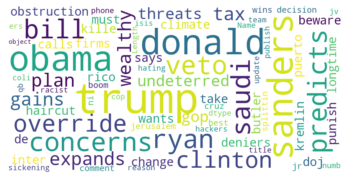

Cloud of words for false articles:


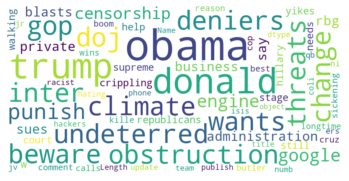

Cloud of words for true articles:


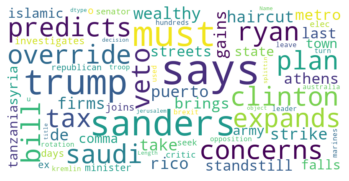

In [61]:
%matplotlib inline
print('Cloud of words for the entire dataset:')
wordcloud(data.title, 100)

print('Cloud of words for false articles:')
wordcloud(data[data.target == 0].title, 100)

print('Cloud of words for true articles:')
wordcloud(data[data.target == 1].title, 100)

#### From the descriptive statistics above: 

- The dataset consists `20,303` unique words after stop words (i.e., *you*, *she*, *and*).
- The median frequency among all words equals to `3`. Meaning, at least a half of all words were mentioned once, twice or three times in the entire dataset.
- The word that was mentioned the most is `trump`. It was mentioned `14,899` times. 

Having `20,303` features for a `40,000`-observation dataset we are risking to encounter **Curse of Dimensionality**. We need to reduce the number of total features before training the model.

In [62]:
data['title'] = stemming(data['title'])

In [63]:
#generate length of titles for each observation
data['title_length'] = data.title.str.split().str.len()
print('mean title length of the fake articles (after stemming): ', data[data.target == 0].title_length.mean())
print('mean title length of the true articles (after stemming): ', data[data.target == 1].title_length.mean())
print('\nmedian title length of the fake articles (after stemming): ', data[data.target == 0].title_length.median())
print('median title length of the true articles (after stemming): ', data[data.target == 1].title_length.median())

mean title length of the fake articles (after stemming):  10.628465567905966
mean title length of the true articles (after stemming):  7.926553672316384

median title length of the fake articles (after stemming):  10.0
median title length of the true articles (after stemming):  8.0


In [64]:
print('distribution of stems frequencies after stemming: ')
pd.Series(' '.join(data.title).split()).value_counts().describe()

distribution of stems frequencies after stemming: 


count    13101.000000
mean        32.007480
std        187.006322
min          1.000000
25%          1.000000
50%          4.000000
75%         16.000000
max      14924.000000
dtype: float64

In [65]:
print('top 10 stems after stemming are: ')
pd.Series(' '.join(data.title).split()).value_counts()[:10]

top 10 stems after stemming are: 


trump         14924
video          8598
say            4131
obama          3264
hillari        2366
hous           2059
watch          2019
u              1937
presid         1929
republican     1843
dtype: int64

#### From the descriptive statistics above (after stemming): 

- The dataset consists `13,101` unique tokens (stems). By stemming we were able to eliminate 7,202 features (35%).
- The median frequency among all tokens equals to `4`.  
- Like in the distribution before stemming, the word that was mentioned the most is `trump`. It was mentioned `14,924` times. 

This is still a high number of potential features. We may need to reduce it more.

In [66]:
# Split the data into two parts: training data (7/10) and other data (3/10)
train_text, val_test_text = train_test_split(data, random_state=1234, test_size=0.3, stratify=data['target'])

# Split other data into two parts: validation data (1/3 * 3/10 = 1/10) and testing data (2/3 * 3/10 = 2/10)
val_text, test_text = train_test_split(val_test_text, random_state=1234, test_size=0.6, stratify=val_test_text['target'])

Example of the `train_text` data frame:

In [67]:
train_text

,title,target,title_length
22242,bodi mexican teenag vanish cabifi ride found,1,7
29487,let boycott begin keurig coffe major compani c...,0,20
15851,one major reason trump give support white supr...,0,8
21254,new york citi watchdog decri irregular primari...,1,8
12613,islam state claim respons blast afghan capit k...,1,8
...,...,...,...
10941,watch colbert takedown cuck steve bannon noth ...,0,9
2860,tucker carlson unload dem strategist post hunt...,0,16
40342,u hous panel take bill spur generic drug develop,1,9
33603,video wow racist statement jeb bush even worst...,0,10


## 2. TF-IDF Step

For our baseline model, we will be using the `TF-IDF` Vectorizer to pre-process articles and then apply Logistic Classifier.

First model will use 1,000 features.

In [68]:
text_transformer, X_train_text, X_val_text, X_test_text = \
    tf_idf_vectorizer(train_text.title, val_text.title,test_text.title, 1000)

Below is the example of 100 features to be used in the model: 

In [69]:
feature_names = text_transformer.get_feature_names_out()
feature_names[:50]

array(['abort', 'absolut', 'abus', 'accept', 'access', 'account', 'accus',
       'act', 'action', 'activist', 'actor', 'actual', 'ad', 'address',
       'administr', 'admit', 'advis', 'advisor', 'afghanistan', 'africa',
       'african', 'agenc', 'agenda', 'agent', 'agre', 'ahead', 'aid',
       'aim', 'air', 'airport', 'al', 'alabama', 'alien', 'alleg', 'alli',
       'allow', 'alreadi', 'ambassador', 'amend', 'america', 'american',
       'amid', 'amnesti', 'anchor', 'angri', 'announc', 'anoth', 'answer',
       'anthem', 'anti'], dtype=object)

In [70]:
print('The number of observations (articles) in  the train data: ', X_train_text.shape[0])
print('The number of features (tokens) in  the train data: ', X_train_text.shape[1])

The number of observations (articles) in  the train data:  31428
The number of features (tokens) in  the train data:  1000


Example of `TF-IDF` matrix, **val_text**, for the validation dataset:

In [71]:
X_val_text.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## 3. Modeling

We will be using the `Logistic Classifier` as our baseline model for training:

In [72]:
logit = LogisticRegression(penalty = 'l2', C = 1, solver= 'sag', multi_class = 'multinomial')
logit.fit(X_train_text, train_text.target)

LogisticRegression(C=1, multi_class='multinomial', solver='sag')

Now that we have trained our model, we will apply it to predict labels (true/false) for articles in the test data and calculate the accuracy score for 1,000 features:

In [73]:
train_predicted_label = logit.predict(X_train_text)
train_accuracy_score = accuracy_score(train_text['target'], train_predicted_label)

predicted_label0 = logit.predict(X_val_text)
accuracy_score0 = accuracy_score(val_text['target'], predicted_label0)

print('Accuracy on the training data: %.2f' % train_accuracy_score)

print('\nMetrics for 1,000-feature model (validation data): \nAccuracy: %.2f' % accuracy_score0)
print('Precision: %.2f' % precision_score(val_text.target, predicted_label0))
print('Recall: %.2f' % recall_score(val_text.target, predicted_label0))
print('F1: %.2f' % f1_score(val_text.target, predicted_label0))

Accuracy on the training data: 0.93

Metrics for 1,000-feature model (validation data): 
Accuracy: 0.92
Precision: 0.91
Recall: 0.93
F1: 0.92


Run Logistic Model on 6,000 features:

In [74]:
text_transformer1, X_train_text1, X_val_text1, X_test_text1 = \
    tf_idf_vectorizer(train_text.title, val_text.title,test_text.title, 6000)

logit = LogisticRegression(penalty = 'l2', C = 1, solver= 'sag', multi_class = 'multinomial')
logit.fit(X_train_text1, train_text.target)

train_predicted_label = logit.predict(X_train_text1)
train_accuracy_score = accuracy_score(train_text.target, train_predicted_label)

predicted_label1 = logit.predict(X_val_text1)
accuracy_score1 = accuracy_score(val_text.target, predicted_label1)

print('Accuracy on the training data: %.2f' % train_accuracy_score)

print('\nMetrics for 6,000-feature model (validation data): \nAccuracy: %.2f' % accuracy_score1)
print('Precision: %.2f' % precision_score(val_text.target, predicted_label1))
print('Recall: %.2f' % recall_score(val_text.target, predicted_label1))
print('F1: %.2f' % f1_score(val_text.target, predicted_label1))

Accuracy on the training data: 0.96

Metrics for 6,000-feature model (validation data): 
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1: 0.94


Run Logistic Model on ALL features (13,101 total):

In [75]:
text_transformer2, X_train_text2, X_val_text2, X_test_text2 = \
    tf_idf_vectorizer(train_text.title, val_text.title,test_text.title, None)

logit = LogisticRegression(penalty = 'l2', C = 1, solver= 'sag', multi_class = 'multinomial')
logit.fit(X_train_text2, train_text.target)

train_predicted_label = logit.predict(X_train_text2)
train_accuracy_score = accuracy_score(train_text.target, train_predicted_label)

predicted_label2 = logit.predict(X_val_text2)
accuracy_score2 = accuracy_score(val_text.target, predicted_label2)

print('Accuracy on the training data: %.2f' % train_accuracy_score)

print('\nMetrics for 13,000-feature model (validation data): \nAccuracy: %.2f' % accuracy_score2)
print('Precision: %.2f' % precision_score(val_text.target, predicted_label2))
print('Recall: %.2f' % recall_score(val_text.target, predicted_label2))
print('F1: %.2f' % f1_score(val_text.target, predicted_label2))

Accuracy on the training data: 0.97

Metrics for 13,000-feature model (validation data): 
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1: 0.94


In [84]:
# initialize list of lists
data = [['1,000', 'Accuracy', accuracy_score0], ['1,000', 'Precision', precision_score(val_text.target, predicted_label0)], ['1,000', 'Recall', recall_score(val_text.target, predicted_label0)], ['1,000', 'F1', f1_score(val_text.target, predicted_label0)],
        ['6,000', 'Accuracy', accuracy_score1], ['6,000','Precision', precision_score(val_text.target, predicted_label1)], ['6,000','Recall',recall_score(val_text.target, predicted_label1)], ['6,000', 'F1', f1_score(val_text.target, predicted_label1)],
        ['13,000','Accuracy', accuracy_score2], ['13,000','Precision', precision_score(val_text.target, predicted_label2)],['13,000','Recall', recall_score(val_text.target, predicted_label2)],['13,000','F1',f1_score(val_text.target, predicted_label2)]] 
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Number of features', 'Type of Metric', 'Metric Value'])

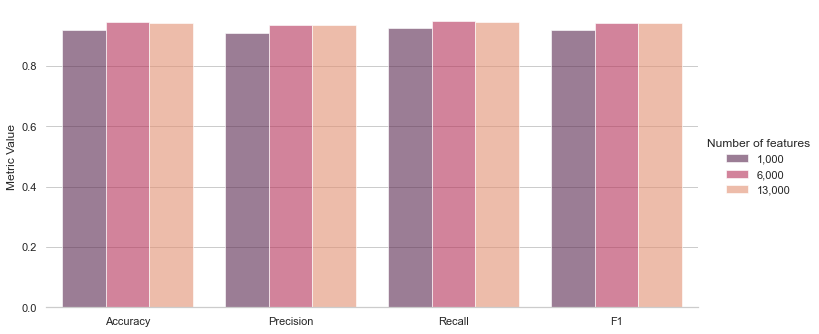

In [104]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data = df,
    kind="bar",
    x="Type of Metric", y="Metric Value", hue="Number of features",
    ci="sd", palette="rocket", alpha=.6, height=5, aspect=2
)
g.despine(left=True)
g.set_axis_labels("", "Metric Value")
g.legend.set_title("Number of features")

Notes form meeting with Cole:

try different models with different # number of features 

1. steming/punctation/stop words/digits - `done`
2. remove article sources - `done`
3. try different # of features - `done`
4. check the average length - `done`

5. metrics - `pending`
6. top 10 features - `pending`